In [23]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Spectrum from sdssJ133702+305539_combined.dat')

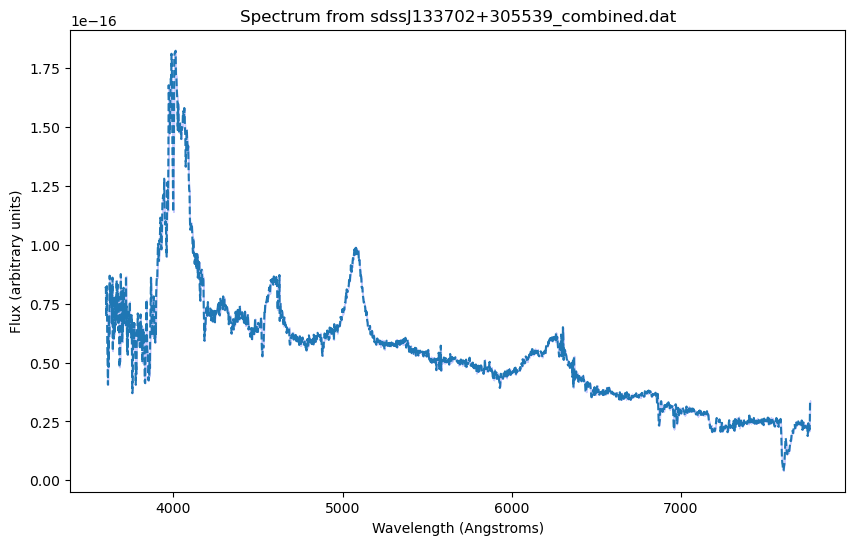

In [24]:
path = "sdssJ133702+305539_combined.dat"

data = np.genfromtxt(path,  skip_header=1, delimiter=' ')
plt.figure(figsize=(10,6))
plt.plot(data[:,0], data[:,1], '--')
plt.fill_between(data[:,0], data[:,1]-data[:,2], data[:,1]+data[:,2], color='blue', alpha=0.2)
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux (arbitrary units)")
plt.title("Spectrum from " + path)

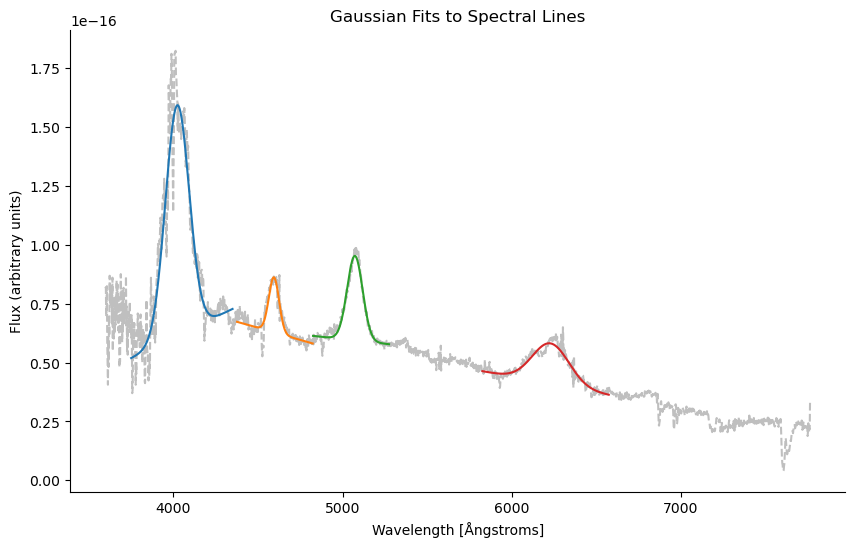

In [31]:
fitpeaks = [4050, 4600, 5050, 6200]
fit_widths = [200, 150, 150, 250]
fit_widths = np.array(fit_widths)*1.5

def gaussian_on_linear_bg(x, amp, cen, wid, slope, intercept):
    return amp * np.exp(-(x-cen)**2 / (2*wid**2)) + slope*x + intercept

plt.figure(figsize=(10,6))
from scipy.optimize import curve_fit
plt.plot(data[:,0], data[:,1], '--', label='Data', alpha=0.5, c ='gray')
for peak, width in zip(fitpeaks, fit_widths):
    mask = (data[:,0] > peak - width) & (data[:,0] < peak + width)
    xdata = data[mask, 0]
    ydata = data[mask, 1]
    yerr = data[mask, 2]

    p0 = [np.max(ydata), peak, width/2, 0, np.median(ydata)]
    popt, pcov = curve_fit(gaussian_on_linear_bg, xdata, ydata, p0=p0, sigma=yerr)

    fitpeak = popt[1]
    fitwidth = popt[2]
    plt.plot(xdata, gaussian_on_linear_bg(xdata, *popt), label=f'Fit at {int(fitpeak)} Å. Width {fitwidth:.4} $\\pm$ {np.sqrt(pcov[2,2]):.4} Å')

plt.xlabel("Wavelength [Ångstroms]")
plt.ylabel("Flux (arbitrary units)")
plt.title("Gaussian Fits to Spectral Lines")
# plt.legend()
sns.despine()
plt.show()

Moment-based fit at peak 4050 Å: Mean = 4046.53571922286, Stddev = 81.01056910717088
Moment-based fit at peak 4600 Å: Mean = 4601.69923394617, Stddev = 31.11143743111696
Moment-based fit at peak 5050 Å: Mean = 5069.080438983554, Stddev = 57.520400663421036
Moment-based fit at peak 6200 Å: Mean = 6208.820898404657, Stddev = 94.12016245272424


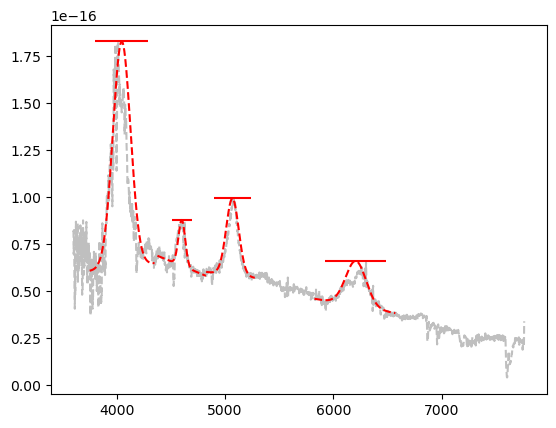

In [21]:
# usign moments
def moment_based_gaussian(x, y):
    """Estimate Gaussian parameters using moments."""
    total = np.sum(y)
    mean = np.sum(x * y) / total
    variance = np.sum(y * (x - mean)**2) / total
    return mean, np.sqrt(variance)

plt.plot(data[:,0], data[:,1], '--', label='Data', alpha=0.5, c ='gray')

for peak, width in zip(fitpeaks, fit_widths):
    mask = (data[:,0] > peak - width) & (data[:,0] < peak + width)
    xdata = data[mask, 0]
    ydata = data[mask, 1]

    # FFind linear background from edges of the window
    left_edge = ydata[0]
    right_edge = ydata[-1]
    slope = (right_edge - left_edge) / (xdata[-1] - xdata[0])
    intercept = left_edge - slope * xdata[0]
    
    ydata_bgsub = ydata - (slope * xdata + intercept)

    mean, stddev = moment_based_gaussian(xdata, ydata_bgsub)
    print(f"Moment-based fit at peak {peak} Å: Mean = {mean}, Stddev = {stddev}")

    # plot horizontal line at amplitude
    amplitude = np.max(ydata_bgsub) 
    plt.hlines(amplitude+ (slope * mean + intercept), mean - 3*stddev, mean + 3*stddev, colors='r',
               label=f'Moment Fit at {int(mean)} Å. Width {stddev:.4} Å')
    
    # also plot the Gaussian for visualization , taking the bg into account
    gaussian_fit = amplitude * np.exp(-(xdata - mean)**2 / (2*stddev**2)) + slope * xdata + intercept
    plt.plot(xdata, gaussian_fit, 'r--')
    
